In [1]:
%matplotlib widget
import numpy as np
import os
import fileinput
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from utilities.foam_automation.caserunner import run_until_convergence, get_endtime
from utilities.foam_automation.computeFoamLossFunc import computeFoamFieldLossFunc
from utilities.foam_automation.set_foam_coeff import set_foam_coef

from utilities.json_io import write_suggestion, write_json, load_coeff_default, load_coeff_bounds, load_history_loss_log, load_suggestion

from utilities.control import initialize
from update_history import register_score
from suggest_coeffs import suggest
import random

# Grid search

## Score chistory_directory = '/home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner'
alculations

In [2]:
history_directory = '/home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner'


In [8]:
# Calculate errors loop
a1_vec = np.around(np.linspace(0.24,0.6,30),4)
betastar_vec = np.around(np.linspace(0.045,0.14,30),4)
ref_df = pd.read_csv('/home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner/refdata.csv')
initialize(directory = history_directory,
           coeff_bounds = {'a1': [0.24,0.6],
                           'betaStar':[0.045,0.14]},
           coeff_default = {'a1':0.31,
                            'betaStar': 0.09},
           restart = True)

for a1 in a1_vec:
    for betastar in betastar_vec:
        casedir = f'/home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/a1_betaStar_phll/case_1p0_a1_{a1}_betaStar_{betastar}'
        foamLoss = computeFoamFieldLossFunc(foamdir=casedir,
                                            ref_df=ref_df,
                                            interp_method='nearest')
        search_point = {'a1': a1,
                        'betaStar': betastar}
        write_suggestion(directory = history_directory, suggestion = search_point)
        last_time = get_endtime(case=casedir)

        save_dict = {
            'params': search_point,
            'foam_mse_U_componentwise_2Dxy': -foamLoss.foam_mse_U_componentwise_2Dxy(foamtime=last_time),
            'foam_mse_U_magnitude_2Dxy': -foamLoss.foam_mse_U_magnitude_2Dxy(foamtime=last_time),
            'foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean': -foamLoss.foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                        coeff_dict=search_point,
                                                                        coeff_default=load_coeff_default(directory=history_directory)),
            'foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean': -foamLoss.foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                        coeff_dict=search_point,
                                                                        coeff_default=load_coeff_default(directory=history_directory)),
            'foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean': -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                        coeff_dict=search_point,
                                                                        coeff_default=load_coeff_default(directory=history_directory)),
            'foam_multi_mape_U_magnitude_2Dxy_mape_k': -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k(foamtime=last_time),
            'foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p25': -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                        coeff_dict=search_point,
                                                                        coeff_default=load_coeff_default(directory=history_directory),lda=0.25),
            'foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p5': -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                coeff_dict=search_point,
                                                                coeff_default=load_coeff_default(directory=history_directory),lda=0.5)
        }

        write_json(history_directory, save_dict, 'lossfuncs_gridsearch_a1_betastar.json', append=True)

Saving coeff_bounds to /home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner/coeff_bounds.json
Saving coeff_default to /home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner/coeff_default.json
Removing old history and suggestion files....
Could not remove a file, it might not exist to start....
Saving suggestion to /home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner/suggestion.json
Saving suggestion to /home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner/suggestion.json
Saving suggestion to /home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner/suggestion.json
Saving suggestion to /home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner/suggestion.json
Saving suggestion to /home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner/suggestion.json
Saving suggestion to /home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner/suggestion.json
Saving suggestion to /home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner/suggestion.json
Saving suggestion to /home/ryley/WDK/ML/foam/run/t

In [3]:
losses_dict = load_history_loss_log(history_directory, 'lossfuncs_gridsearch_a1_betastar.json')

## Optimum points

In [7]:
ind_max = np.argmax(losses_dict['foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p5'])
a1_opt = losses_dict['a1'][ind_max]
betastar_opt = losses_dict['betaStar'][ind_max]
loss_opt = losses_dict['foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p5'][ind_max]
print(f"a1: {a1_opt}")
print(f"betaStar: {betastar_opt}")
print(f"Score: {loss_opt}")


a1: 0.3393
betaStar: 0.0745
Score: -0.40044740367131915


In [63]:
a1_vec = np.around(np.linspace(0.15,0.8,300),4)
betastar_vec = np.around(np.linspace(0.045,0.25,100),4)
history_directory = '/home/ryley/WDK/ML/foam/run/turbo-rans/gridsearch/tuner'

a1_combined, betastar_combined = np.meshgrid(np.around(np.linspace(0.24,0.6,30),4),
                                             np.around(np.linspace(0.045,0.14,30),4))
a1_combined = a1_combined.flatten()
betastar_combined = betastar_combined.flatten()

In [8]:
x = losses_dict['a1']
y = losses_dict['betaStar']
loss = losses_dict['foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p5']

-0.40044740367131915


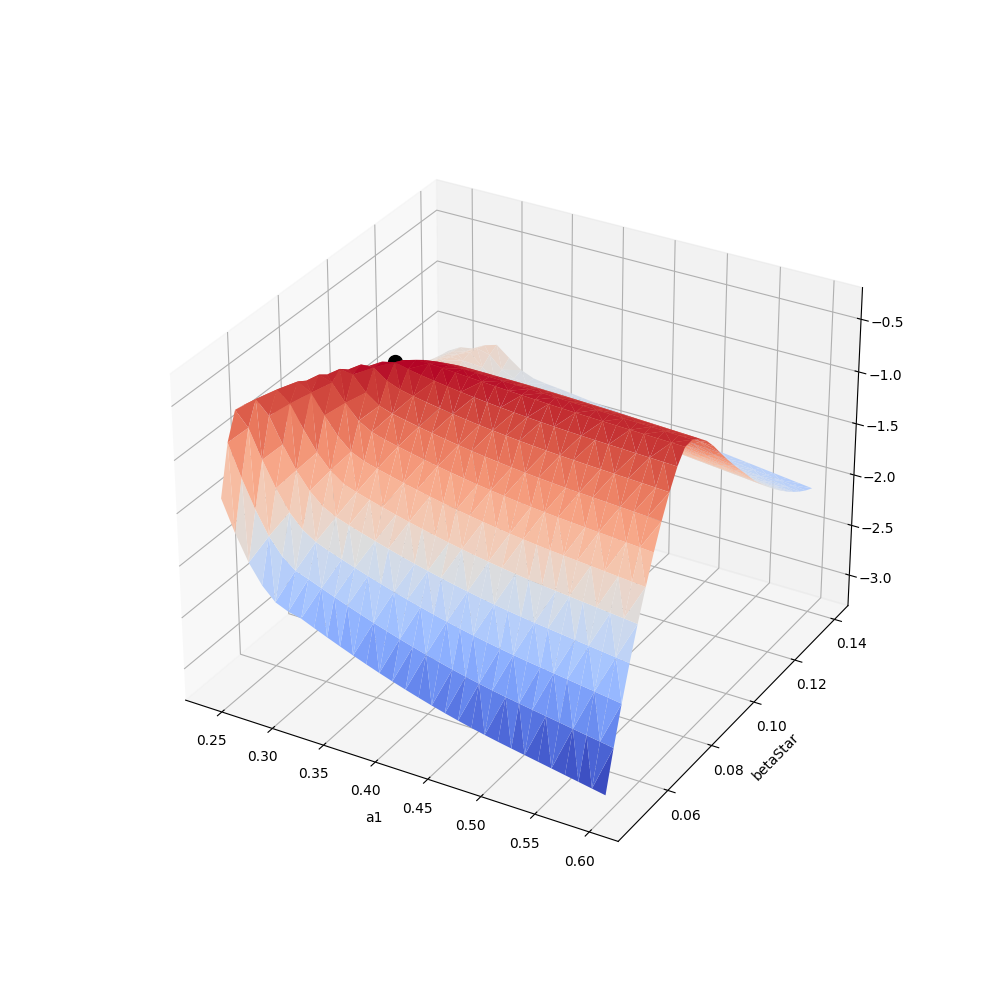

In [9]:

%matplotlib notebook
from matplotlib import cm
fig, ax = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_trisurf(x,y,loss, 
                       cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.scatter(x[np.argmax(loss)],y[np.argmax(loss)],max(loss),marker='o',color='k',s=100)

ax.set_xlabel('a1')
ax.set_ylabel('betaStar')
print(max(loss))
plt.isinteractive()
plt.show()

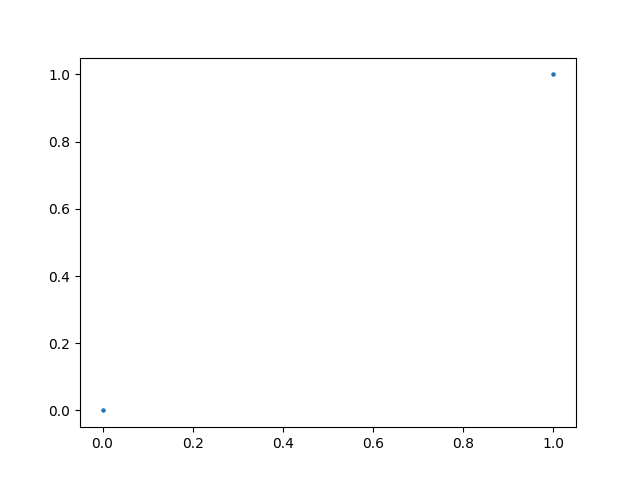

In [3]:
# Matplotlib Scatter Plot
#%matplotlib widget
%matplotlib widget
plt.scatter(x=[0,1],y=[0,1],s=5)
plt.show()



/tmp/ipykernel_7422/3558057789.py:7: UserWarning: The following kwargs were not used by contour: 'linewidth'
  surf = ax.tricontourf(x, y, loss, cmap=cm.coolwarm,


Text(0, 0.5, 'betaStar')

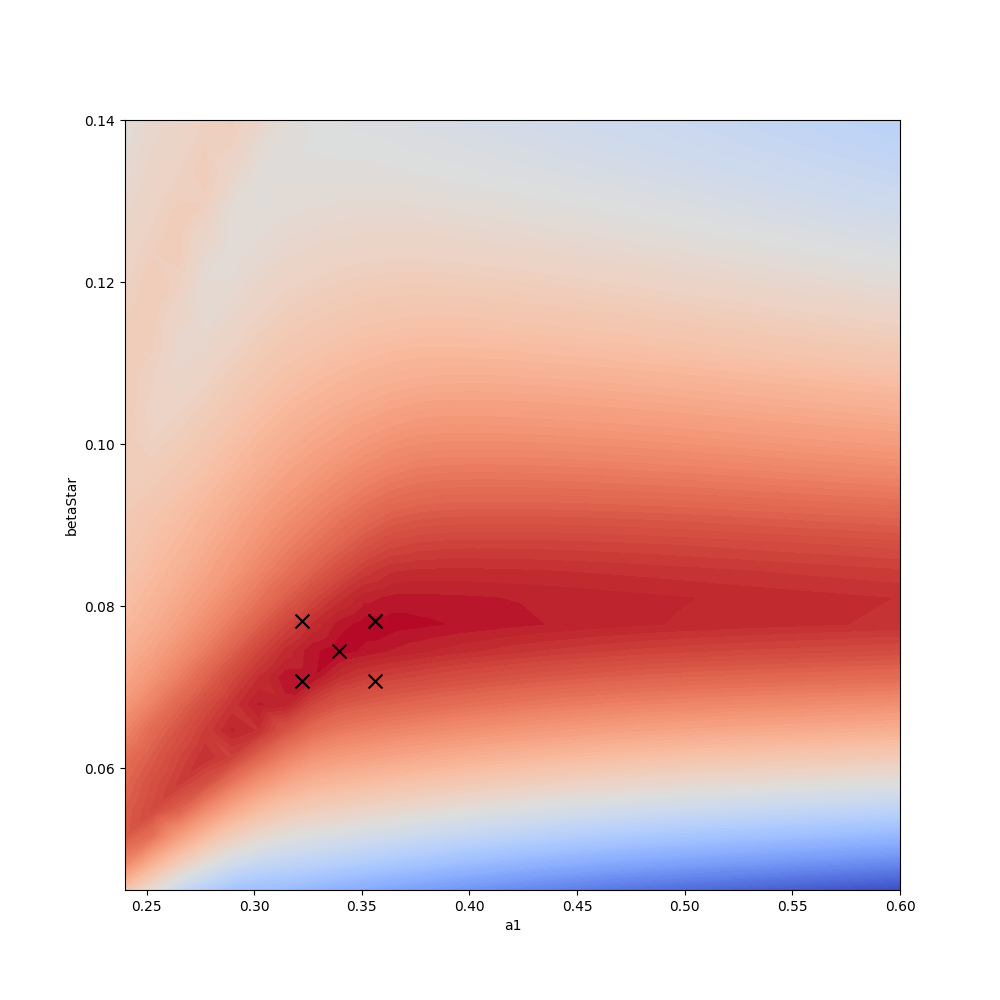

In [43]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(10,10))
x = losses_dict['a1']
y = losses_dict['betaStar']
loss = losses_dict['foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p5']
# Plot the surface.
surf = ax.tricontourf(x, y, loss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,levels=100)
#ax.clabel(surf, inline=True, fontsize=10)
ax.scatter(x[np.argmax(loss)],y[np.argmax(loss)],marker='x',color='k',s=100)
ax.scatter(x[np.argmax(loss)]*1.05,y[np.argmax(loss)]*1.05,marker='x',color='k',s=100)
ax.scatter(x[np.argmax(loss)]*1.05,y[np.argmax(loss)]*1.05,marker='x',color='k',s=100)
ax.scatter(x[np.argmax(loss)]*1.05,y[np.argmax(loss)]*.95,marker='x',color='k',s=100)
ax.scatter(x[np.argmax(loss)]*.95,y[np.argmax(loss)]*1.05,marker='x',color='k',s=100)
ax.scatter(x[np.argmax(loss)]*0.95,y[np.argmax(loss)]*0.95,marker='x',color='k',s=100)

ax.set_xlabel('a1')
ax.set_ylabel('betaStar')



# Hyperparameter search

[-1.0156718130615825, -2.0762970614792233, -1.5073555950862958, -1.9718652912056505, -1.190318389382756, -1.1877978377685303, -0.7337237612525956, -0.46477291150092076, -0.7731982213765527, -0.7845775108707709, -0.6204909343792326, -1.3953910297398664, -1.9374761651216157, -0.9689702566648473, -0.4645123982797668, -0.46675062848624554, -0.7029798589028371, -0.5726745404534578, -0.43936035233638127, -1.0791585272765085, -0.5547227866822204, -0.4331371304857508, -3.111911914684884, -1.5168126851947221, -1.8527491426620912, -2.96219235981434, -1.0303515692819025, -1.7094091649152956, -0.42259177147630284, -1.1293346429347566, -0.5121899802108119, -0.51204628087641, -0.8135000671189996, -1.9163598273753366, -0.9418285105617876, -0.4036925232294872]


/tmp/ipykernel_7422/3682416077.py:19: UserWarning: The following kwargs were not used by contour: 'linewidth'
  surf = ax.tricontourf(losses_dict['a1'], losses_dict['betaStar'], losses_dict['foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p5'], cmap=cm.coolwarm,


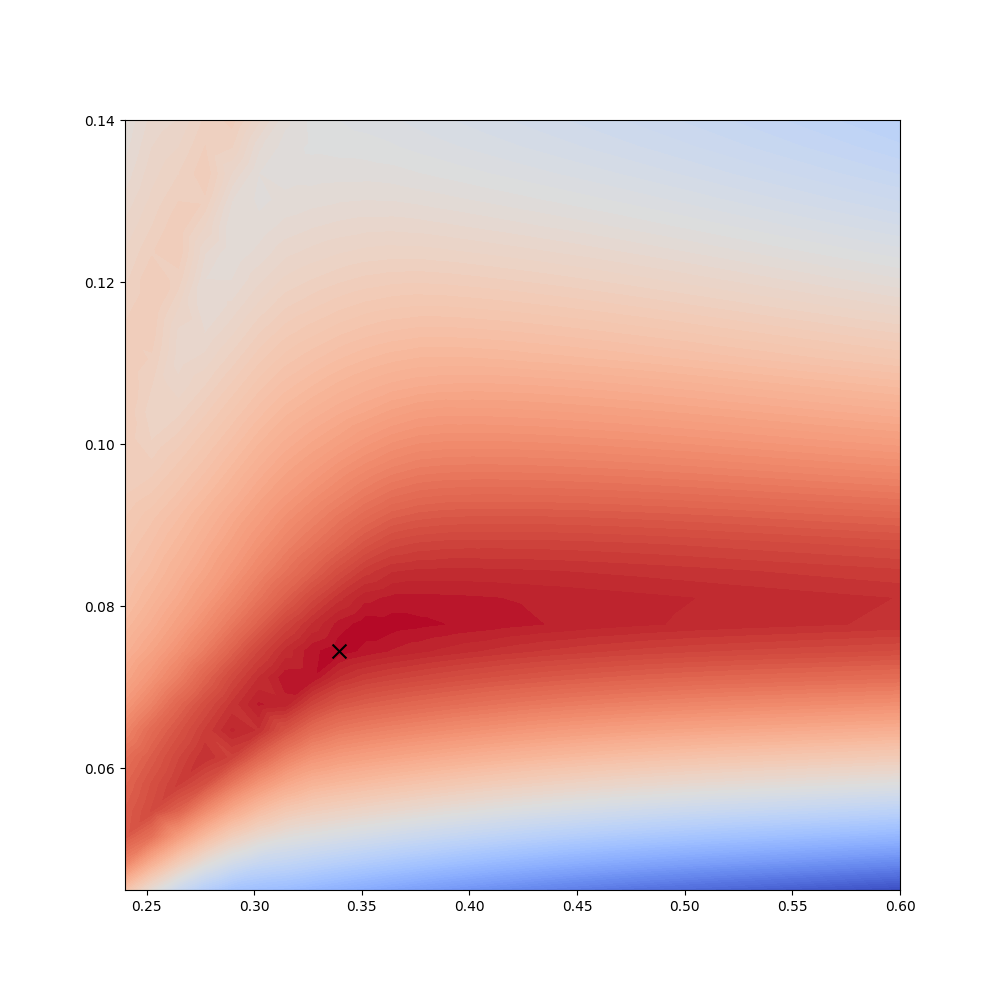

In [44]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
n=5
tunerdir = os.path.join(f'/home/ryley/WDK/ML/foam/run/turbo-rans/hyperparameter_exploration/ei_xi_0.0001_case_1p0_{n}','tuner')
tuning_dict = load_history_loss_log(tunerdir, 'history.json')
x = tuning_dict['a1']
y = tuning_dict['betaStar']
loss = tuning_dict['target']
print(loss)
xyloss=np.column_stack((x,y,loss))
#print(xyloss)
#print(xyloss)
#xyloss=xyloss[xyloss[:,2].argsort()]
def animate(i):
    graph.set_data(x[:i+1], y[:i+1])
    return graph

fig,ax = plt.subplots(figsize=(10,10))
surf = ax.tricontourf(losses_dict['a1'], losses_dict['betaStar'], losses_dict['foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p5'], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,levels=100)
ax.scatter(a1_opt,betastar_opt,marker='x',color='k',s=100)

plt.xlim(0.24, 0.6)
plt.ylim(0.045, .14)
graph, = plt.plot([], [],'o',color='k')
ani = FuncAnimation(fig, animate, frames=len(x)+1, interval=200)
plt.show()
ani.save(f"animation_ei_{n}.gif", dpi=300,
         writer=PillowWriter(fps=5))

## Analysis

In [39]:
xi = [.03,.04]#[.03,.04,.05,.06,.07]
kappa = [3.0,3.5]#np.linspace(3, 7, 9)
kind = ['ucb','ei','poi']
N = 10

results_dict = dict.fromkeys(kind)

for util in kind:
    if util == 'ucb': 
        param = kappa
        param_name = 'kappa'
    else: 
        param = xi
        param_name = 'xi'
    
    n_iter = np.empty((N,len(param)))
    for i,param_i in enumerate(param):
        for n in range(N):
            tunerdir = os.path.join(f'/home/ryley/WDK/ML/foam/run/turbo-rans/hyperparameter_exploration/{util}_{param_name}_{param_i}_case_1p0_{n}','tuner')
            tuning_dict = load_history_loss_log(tunerdir, 'history.json')
            n_iter[n,i] = len(tuning_dict['target'])
    results_dict[util] = n_iter
print(results_dict)
summary_dict = dict.fromkeys(kind)

for util in kind:
    results = results_dict[util]
    #print(results)
    average = np.mean(results,axis=0)
    std_error = np.std(results,axis = 0,ddof=2) / np.sqrt(len(results))
    summary_dict[util] = [average,std_error]
    #print(average,std_error)

print(summary_dict)

{'ucb': array([[ 90.,  98.],
       [ 62.,  90.],
       [ 77.,  95.],
       [ 75., 112.],
       [ 71., 102.],
       [ 62.,  71.],
       [ 91.,  69.],
       [112.,  81.],
       [ 74.,  81.],
       [ 72.,  86.]]), 'ei': array([[ 80.,  24.],
       [ 42.,  60.],
       [112., 112.],
       [ 82.,  61.],
       [ 71.,  97.],
       [ 75.,  71.],
       [ 83.,  50.],
       [ 81.,  54.],
       [ 70., 107.],
       [ 31.,  46.]]), 'poi': array([[ 52.,  72.],
       [ 57.,  54.],
       [ 72.,  65.],
       [ 73., 112.],
       [ 19.,  64.],
       [ 24.,  24.],
       [ 54.,  75.],
       [ 88.,  38.],
       [ 84.,  37.],
       [ 73.,  64.]])}
{'ucb': [array([78.6, 88.5]), array([5.10930524, 4.57506831])], 'ei': [array([72.7, 68.2]), array([7.5466052, 9.5914024])], 'poi': [array([59.6, 60.5]), array([7.84729253, 8.27080709])]}


(0.0, 100.0)

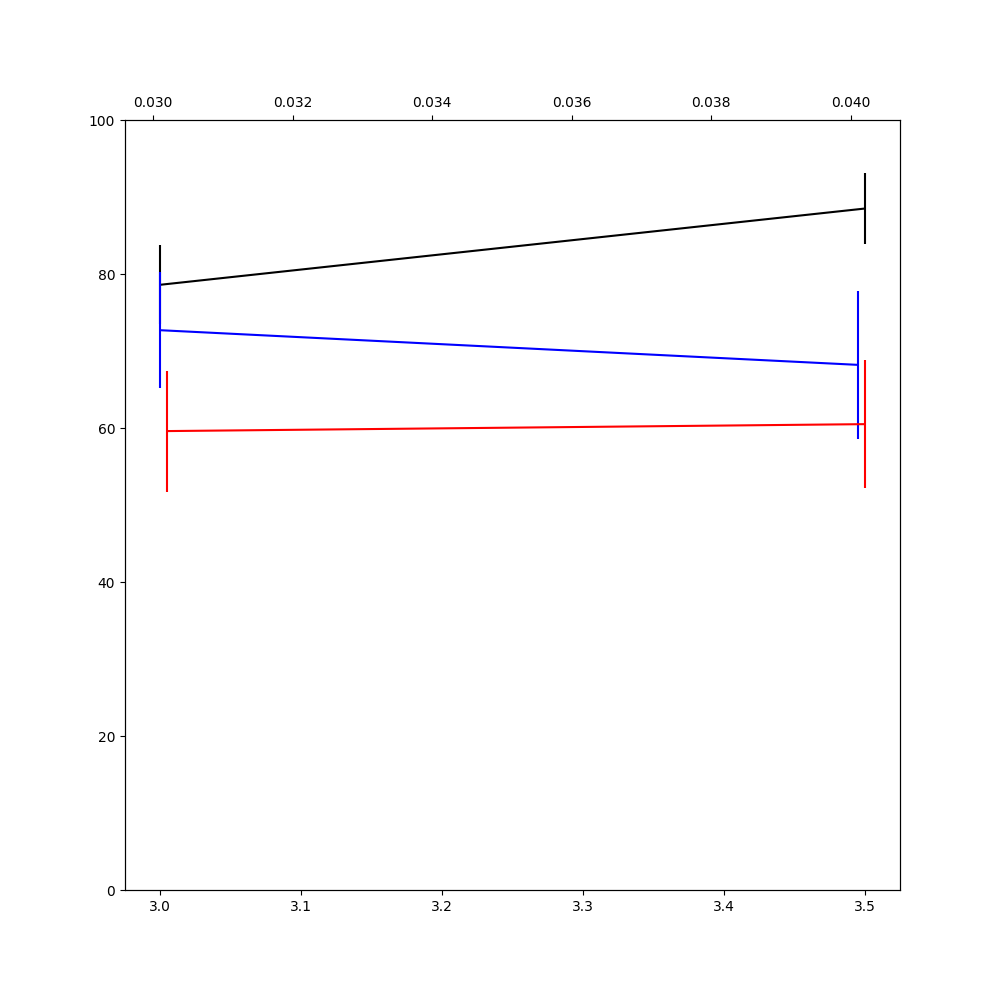

In [40]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(10,10))
#x = losses_dict['a1']
#y = losses_dict['betaStar']
#loss = losses_dict['foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p5']
# Plot the surface.
#surf = ax.tricontourf(x, y, loss, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False,levels=100)
#ax.clabel(surf, inline=True, fontsize=10)
#ax.scatter(x[np.argmax(loss)],y[np.argmax(loss)],marker='x',color='k',s=100)
#ax.scatter(x[np.argmax(loss)]*1.025,y[np.argmax(loss)]*1.025,marker='x',color='k',s=100)
#ax.scatter(x[np.argmax(loss)]*1.025,y[np.argmax(loss)]*.975,marker='x',color='k',s=100)
#ax.scatter(x[np.argmax(loss)]*.975,y[np.argmax(loss)]*1.025,marker='x',color='k',s=100)

#ax.scatter(x[np.argmax(loss)]*0.975,y[np.argmax(loss)]*0.975,marker='x',color='k',s=100)
ax.errorbar(kappa, summary_dict['ucb'][0], yerr=summary_dict['ucb'][1], fmt='k')
ax2 = ax.twiny()
ax2.errorbar([x+.0001 for x in xi], summary_dict['ei'][0], yerr=summary_dict['ei'][1], fmt='b')
ax2.errorbar([x+.0002 for x in xi], summary_dict['poi'][0], yerr=summary_dict['poi'][1], fmt='r')

ax.set_ylim([0,100])
#ax.set_xlabel('a1')
#ax.set_ylabel('betaStar')



In [16]:
print(results_dict)

{'ucb': array([[ 90.,  98.],
       [ 62.,  90.],
       [ 77.,  95.],
       [ 75., 112.],
       [ 71., 102.],
       [ 62.,  71.],
       [ 91.,  69.],
       [112.,  81.],
       [ 74.,  81.],
       [ 72.,  86.]]), 'ei': array([[ 80.,  24.],
       [ 42.,  60.],
       [112., 112.],
       [ 82.,  61.],
       [ 71.,  97.],
       [ 75.,  71.],
       [ 83.,  50.],
       [ 81.,  54.],
       [ 70., 107.],
       [ 31.,  46.]]), 'poi': array([[ 52.,  72.],
       [ 57.,  54.],
       [ 72.,  65.],
       [ 73., 112.],
       [ 19.,  64.],
       [ 24.,  24.],
       [ 54.,  75.],
       [ 88.,  38.],
       [ 84.,  37.],
       [ 73.,  64.]])}


In [ ]:

for n in range(10):
casedir = f'/home/ryley/WDK/ML/foam/run/turbo-rans/hyperparameter_exploration/case_1p0_{n}'
os.system(f'cp -r /home/ryley/WDK/ML/foam/run/turbo-rans/hyperparameter_exploration/case_1p0_template {casedir}')
tunerdir = os.path.join(casedir,'tuner')
iterations=20
#ref_df = pd.read_csv(os.path.join(tunerdir,'refdata.csv'))
initialize(directory = tunerdir,
           coeff_bounds = None,
           coeff_default = None,
           restart = True)

foamLoss = computeFoamFieldLossFunc(foamdir=casedir,
                                    ref_df=ref_df,
                                    interp_method='nearest')

search_point = load_coeff_default(directory=tunerdir)
score = write_suggestion_run_case_register_score(casedir,tunerdir,search_point)

a1_rand = np.random.uniform(.24, .6, size=(5))
betaStar_rand = np.random.uniform(.045, .14, size=(5))
for a1, betaStar in zip(a1_rand,betaStar_rand):
    print('RANDOM search point:')
    search_point = {"a1": a1,
                    "betaStar": betaStar}
    print(search_point)
    score = write_suggestion_run_case_register_score(casedir,tunerdir,search_point)
i=0
while abs(score-max_score) > 0.05*abs(max_score):
    suggest(directory=tunerdir,
               random_state=n,
           utility_kind=utility,
           kappa = 2.5)
    search_point = load_suggestion(directory=tunerdir)
    score = write_suggestion_run_case_register_score(casedir,tunerdir,search_point)
    print(score)
    i+=1

# Bayesian optimization

## Search for optimal optimizer hyperparameters

# Analysis and plotting

## Comparison of loss functions

NameError: name 'load_history_to_dict' is not defined

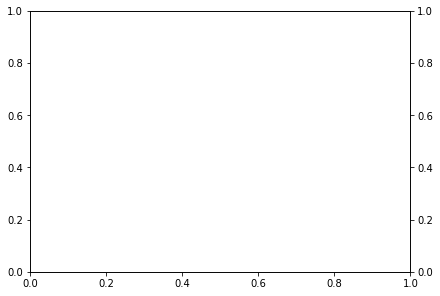

In [17]:
history_directory = 'foam/gridsearch/tuner/'
def load_history(historyfile):
    history = load_history_to_dict(history_directory,historyfile)
    param = [d['params']['a1'] for d in history]
    target = [d['target'] for d in history]  
    return param, target

def get_max_xy(historyfile):
    x,y = load_history(historyfile)
    ind = np.argmax(y)
    return x[ind],y[ind]

def get_percent_xy(historyfile):
    x,y = load_history(historyfile)
    y_find = max(y)-abs(max(y))*0.025
    difference_array = abs(np.asarray(y) - y_find)
    ind = np.argmin(difference_array)
    return x[ind],y[ind]

fig, ax1 = plt.subplots(constrained_layout=True)
ax2 = ax1.twinx()

ax1.plot(load_history('history_foam_mse_U_componentwise_2Dxy.json')[0],
         load_history('history_foam_mse_U_componentwise_2Dxy.json')[1],
         'k--',
         label='MSE_U_componentwise')

ax1.scatter(x = get_max_xy('history_foam_mse_U_componentwise_2Dxy.json')[0],
            y = get_max_xy('history_foam_mse_U_componentwise_2Dxy.json')[1],
            c='k')

ax1.scatter(x = get_percent_xy('history_foam_mse_U_componentwise_2Dxy.json')[0],
            y = get_percent_xy('history_foam_mse_U_componentwise_2Dxy.json')[1],
            facecolors='none', edgecolors='k')

ax1.plot(load_history('history_foam_mse_U_magnitude_2Dxy.json')[0],
         load_history('history_foam_mse_U_magnitude_2Dxy.json')[1],
         'b--',
         label='MSE_U_mag')
ax1.scatter(x = get_max_xy('history_foam_mse_U_magnitude_2Dxy.json')[0],
            y = get_max_xy('history_foam_mse_U_magnitude_2Dxy.json')[1],
            c='b')
ax1.scatter(x = get_percent_xy('history_foam_mse_U_magnitude_2Dxy.json')[0],
            y = get_percent_xy('history_foam_mse_U_magnitude_2Dxy.json')[1],
            facecolors='none', edgecolors='b')

ax1.plot(load_history('history_foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean.json')[0],
         load_history('history_foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean.json')[1],
         label='MSE_U_mag_coef',c='b')
ax1.scatter(x = get_max_xy('history_foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean.json')[0],
            y = get_max_xy('history_foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean.json')[1],
            c='b')

ax2.plot(load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[0],
         load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[1],
         'brown',linestyle='dashed',
         label='MAPE_U_mag_k')

ax2.scatter(x = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[0],
            y = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[1],
            c='brown')
ax2.scatter(x = get_percent_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[0],
            y = get_percent_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[1],
            facecolors='none', edgecolors='brown')

ax2.plot(load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean.json')[0],
         load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean.json')[1],
         'orange',
         label=r'MAPE_U_mag_k_coef, $\lambda$ =1')
ax2.scatter(x = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean.json')[0],
            y = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean.json')[1],
            c='orange')

ax2.plot(load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p5.json')[0],
         load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p5.json')[1],
         'darkgoldenrod',
         label=r'MAPE_U_mag_k_coef, $\lambda$ =0.5')
ax2.scatter(x = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p5.json')[0],
            y = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p5.json')[1],
            c='darkgoldenrod')

ax2.plot(load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p25.json')[0],
         load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p25.json')[1],
         'red',
         label=r'MAPE_U_mag_k_coef, $\lambda$ =0.25')

ax2.scatter(x = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p25.json')[0],
            y = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p25.json')[1],
            c='red')

ax1.set_ylim([-0.000040,0])
ax2.set_ylim([-2,0])
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=4)
ax1.set_xlabel(r'$a_1$')
ax1.set_ylabel('MSE loss functions')
ax2.set_ylabel('MAPE loss functions')


## Number of iterations

Text(0, 0.5, 'MAPE" loss functions')

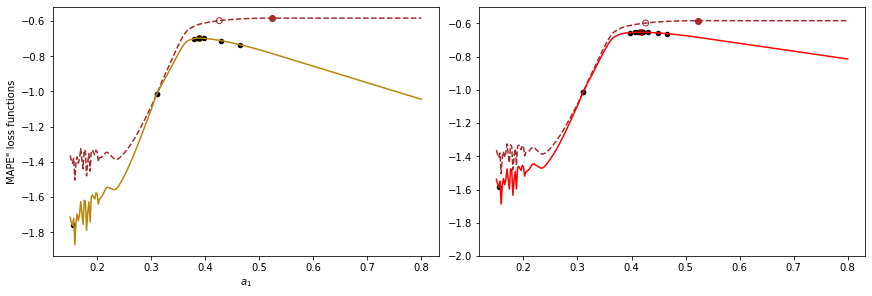

In [25]:
def load_history(historyfile,history_directory='foam/gridsearch_a1_phll/tuner/'):
    history = load_history_to_dict(history_directory,historyfile)
    param = [d['params']['a1'] for d in history]
    target = [d['target'] for d in history]  
    
    return param, target
def get_max_xy(historyfile):
    x,y = load_history(historyfile)
    ind = np.argmax(y)
    return x[ind],y[ind]

def get_percent_xy(historyfile):
    x,y = load_history(historyfile)
    y_find = max(y)-abs(max(y))*0.025
    difference_array = abs(np.asarray(y) - y_find)
    ind = np.argmin(difference_array)
    return x[ind],y[ind]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), constrained_layout=True)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[0],
         load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[1],
         'brown',linestyle='dashed',
         label='MAPE_U_mag_k')
ax1.scatter(x = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[0],
            y = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[1],
            c='brown')
ax1.scatter(x = get_percent_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[0],
            y = get_percent_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[1],
            facecolors='none', edgecolors='brown')


ax2.plot(load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[0],
         load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[1],
         'brown',linestyle='dashed',
         label='MAPE_U_mag_k')

ax2.scatter(x = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[0],
            y = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[1],
            c='brown')
ax2.scatter(x = get_percent_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[0],
            y = get_percent_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')[1],
            facecolors='none', edgecolors='brown')


ax1.plot(load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p5.json')[0],
         load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p5.json')[1],
         'darkgoldenrod',
         label=r'MAPE_U_mag_k_coef, $\lambda$ =0.5')
ax1.scatter(x = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p5.json')[0],
            y = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p5.json')[1],
            c='darkgoldenrod')

ax1.scatter(x = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p5.json')[0],
            y = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p5.json')[1],
            c='darkgoldenrod')
ax1.scatter(x = load_history('history.json',history_directory='foam/bayesian_a1_phll/case_1p0_lda0p5_10iter/tuner')[0],
            y = load_history('history.json',history_directory='foam/bayesian_a1_phll/case_1p0_lda0p5_10iter/tuner')[1],
            facecolors='k', edgecolors='k',s=20)


ax2.plot(load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p25.json')[0],
         load_history('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p25.json')[1],
         'red',
         label=r'MAPE_U_mag_k_coef, $\lambda$ =0.25')
ax2.scatter(x = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p25.json')[0],
            y = get_max_xy('history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p25.json')[1],
            c='red')

ax2.scatter(x = load_history('history.json',history_directory='foam/bayesian_a1_phll/case_1p0_lda0p25_10iter/tuner')[0],
            y = load_history('history.json',history_directory='foam/bayesian_a1_phll/case_1p0_lda0p25_10iter/tuner')[1],
            facecolors='k', edgecolors='k',s=20)


ax2.set_ylim([-2,-.5])
ax2.set_ylim([-2,-.5])

lines, labels = ax1.get_legend_handles_labels()
ax1.set_xlabel(r'$a_1$')
ax1.set_ylabel('MAPE" loss functions')


## 

# Old code

In [60]:
param_relUkc,target_relUkc = load_history('history_relUkc.json')
param_relUkc,target_relUkc = load_history('history_relUkc.json')

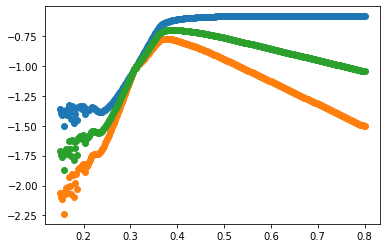

In [5]:

plt.scatter(param_relUk,target_relUk,label='relUk')
plt.scatter(param_relUkc,target_relUkc,label='relUkc')
plt.scatter(param_relUkc05,target_relUkc05,label='relUkc05')

#print(target_comp[0:5])
#print(target_mag[0:5])
#print(target_mag)

In [17]:
def print_bare_goals_at_selected(ind):
    print(f'Point sel: {param_comp[ind]}')
    print(f'relUk max: {target_relUk[ind]}') 
    print(f'error mag: {target_mag[ind]}') 

print('relUk max:')
print_bare_goals_at_selected(np.argmax(target_relUk))

print('Error max max:')
print_bare_goals_at_selected(np.argmax(target_mag))

print('rel1:')
print_bare_goals_at_selected(np.argmax(target_rel1))

print('rel2:')
print_bare_goals_at_selected(np.argmax(target_rel2))

print('relUkc:')
print_bare_goals_at_selected(np.argmax(target_relUkc))

print('relUkc05')
print_bare_goals_at_selected(np.argmax(target_relUkc05))


relUk max:
Point sel: 0.5239
relUk max: -0.583446843127357
error mag: -1.9043332771432456e-06
Error max max:
Point sel: 0.487
relUk max: -0.5850325132177929
error mag: -1.9029594592617798e-06
rel1:
Point sel: 0.387
relUk max: -0.6201985266448174
error mag: -2.0137207480104776e-06
rel2:
Point sel: 0.3761
relUk max: -0.634919507648456
error mag: -2.0907158259925327e-06
relUkc:
Point sel: 0.3761
relUk max: -0.634919507648456
error mag: -2.0907158259925327e-06
relUkc05
Point sel: 0.3891
relUk max: -0.6182589673434529
error mag: -2.004407892737836e-06


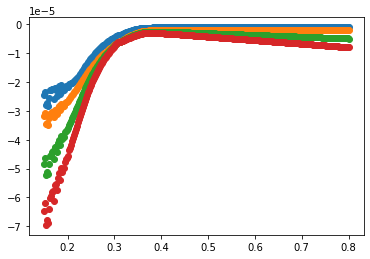

In [7]:
import matplotlib.pyplot as plt

plt.scatter(param_comp,target_comp,label='comp')
plt.scatter(param_mag,target_mag,label='mag')
plt.scatter(param_rel1,target_rel1,label='rel1')
plt.scatter(param_rel2,target_rel2,label='rel2')

#print(target_comp[0:5])
#print(target_mag[0:5])
#print(target_mag)

In [20]:
import pprint
pprint.pprint(history)

[{'datetime': {'datetime': '2022-06-02 19:11:22', 'delta': 0.0, 'elapsed': 0.0},
  'params': {'a1': 0.15},
  'target': 2.466547322840756e-05},
 {'datetime': {'datetime': '2022-06-02 19:11:22', 'delta': 0.0, 'elapsed': 0.0},
  'params': {'a1': 0.1522},
  'target': 2.3300893836578992e-05},
 {'datetime': {'datetime': '2022-06-02 19:11:23', 'delta': 0.0, 'elapsed': 0.0},
  'params': {'a1': 0.1543},
  'target': 2.7916139904196577e-05},
 {'datetime': {'datetime': '2022-06-02 19:11:23', 'delta': 0.0, 'elapsed': 0.0},
  'params': {'a1': 0.1565},
  'target': 2.7443275276943687e-05},
 {'datetime': {'datetime': '2022-06-02 19:11:23', 'delta': 0.0, 'elapsed': 0.0},
  'params': {'a1': 0.1587},
  'target': 2.8174783522166515e-05},
 {'datetime': {'datetime': '2022-06-02 19:11:24', 'delta': 0.0, 'elapsed': 0.0},
  'params': {'a1': 0.1609},
  'target': 2.5641766501330933e-05},
 {'datetime': {'datetime': '2022-06-02 19:11:24', 'delta': 0.0, 'elapsed': 0.0},
  'params': {'a1': 0.163},
  'target': 2.26785

In [24]:
print(param)

[0.15, 0.1522, 0.1543, 0.1565, 0.1587, 0.1609, 0.163, 0.1652, 0.1674, 0.1696, 0.1717, 0.1739, 0.1761, 0.1783, 0.1804, 0.1826, 0.1848, 0.187, 0.1891, 0.1913, 0.1935, 0.1957, 0.1978, 0.2, 0.2022, 0.2043, 0.2065, 0.2087, 0.2109, 0.213, 0.2152, 0.2174, 0.2196, 0.2217, 0.2239, 0.2261, 0.2283, 0.2304, 0.2326, 0.2348, 0.237, 0.2391, 0.2413, 0.2435, 0.2457, 0.2478, 0.25, 0.2522, 0.2543, 0.2565, 0.2587, 0.2609, 0.263, 0.2652, 0.2674, 0.2696, 0.2717, 0.2739, 0.2761, 0.2783, 0.2804, 0.2826, 0.2848, 0.287, 0.2891, 0.2913, 0.2935, 0.2957, 0.2978, 0.3, 0.3022, 0.3043, 0.3065, 0.3087, 0.3109, 0.313, 0.3152, 0.3174, 0.3196, 0.3217, 0.3239, 0.3261, 0.3283, 0.3304, 0.3326, 0.3348, 0.337, 0.3391, 0.3413, 0.3435, 0.3457, 0.3478, 0.35, 0.3522, 0.3543, 0.3565, 0.3587, 0.3609, 0.363, 0.3652, 0.3674, 0.3696, 0.3717, 0.3739, 0.3761, 0.3783, 0.3804, 0.3826, 0.3848, 0.387, 0.3891, 0.3913, 0.3935, 0.3957, 0.3978, 0.4, 0.4022, 0.4043, 0.4065, 0.4087, 0.4109, 0.413, 0.4152, 0.4174, 0.4196, 0.4217, 0.4239, 0.4261, 0

In [6]:
# Calculate errors loop

ref_df = pd.read_csv('foam/gridsearch_a1_phll/tuner/refdata.csv')
initialize(directory = history_directory,
           coeff_bounds = {'a1':[min(a1_vec),max(a1_vec)]},
           coeff_default = {'a1': 0.31},
           restart = True)

for a1 in a1_vec:
    casedir = f'foam/gridsearch_a1_phll/case_1p0_a1_{a1}'
    foamLoss = computeFoamFieldLossFunc(foamdir=casedir,
                                        ref_df=ref_df,
                                        interp_method='nearest')
    search_point = {'a1': a1}
    write_suggestion(directory = history_directory, suggestion = search_point)
    last_time = get_endtime(case=casedir)
    
    save_dict = {
        'parmas': search_point,
        'foam_mse_U_componentwise_2Dxy': -foamLoss.foam_mse_U_componentwise_2Dxy(foamtime=last_time),
        'foam_mse_U_magnitude_2Dxy': -foamLoss.foam_mse_U_magnitude_2Dxy(foamtime=last_time),
        'foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean': -foamLoss.foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory)),
        'foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean': -foamLoss.foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory)),
        'foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean': -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory)),
        'foam_multi_mape_U_magnitude_2Dxy_mape_k': -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k(foamtime=last_time),
        'foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p25': -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory),lda=0.25),
        'foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda_0p5': -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                            coeff_dict=search_point,
                                                            coeff_default=load_coeff_default(directory=history_directory),lda=0.t5)
    }
    
    write_json(history_directory, save_dict, 'lossfuncs_gridsearch.json')
    score1 = -foamLoss.foam_mse_U_componentwise_2Dxy(foamtime=last_time)
    score2 = -foamLoss.foam_mse_U_magnitude_2Dxy(foamtime=last_time)
    score3 = -foamLoss.foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score4 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score5 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score6 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k(foamtime=last_time)
    register_score(score=score1, 
                   directory = history_directory)
os.system(f"mv {os.path.join(history_directory,'history.json')} {os.path.join(history_directory,'history_foam_mse_U_componentwise_2Dxy.json')}")

for a1 in a1_vec:
    casedir = f'foam/gridsearch_a1_phll/case_1p0_a1_{a1}'
    foamLoss = computeFoamFieldLossFunc(foamdir=casedir,
                                        ref_df=ref_df,
                                        interp_method='nearest')
    search_point = {'a1': a1}
    write_suggestion(directory = history_directory, suggestion = search_point)
    last_time = get_endtime(case=casedir)
    score1 = -foamLoss.foam_mse_U_componentwise_2Dxy(foamtime=last_time)
    score2 = -foamLoss.foam_mse_U_magnitude_2Dxy(foamtime=last_time)
    score3 = -foamLoss.foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score4 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score5 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score6 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k(foamtime=last_time)
    register_score(score=score2, 
                   directory = history_directory)
os.system(f"mv {os.path.join(history_directory,'history.json')} {os.path.join(history_directory,'history_foam_mse_U_magnitude_2Dxy.json')}")

for a1 in a1_vec:
    casedir = f'foam/gridsearch_a1_phll/case_1p0_a1_{a1}'
    foamLoss = computeFoamFieldLossFunc(foamdir=casedir,
                                        ref_df=ref_df,
                                        interp_method='nearest')
    search_point = {'a1': a1}
    write_suggestion(directory = history_directory, suggestion = search_point)
    last_time = get_endtime(case=casedir)
    score1 = -foamLoss.foam_mse_U_componentwise_2Dxy(foamtime=last_time)
    score2 = -foamLoss.foam_mse_U_magnitude_2Dxy(foamtime=last_time)
    score3 = -foamLoss.foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score4 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score5 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score6 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k(foamtime=last_time)
    register_score(score=score3, 
                   directory = history_directory)
os.system(f"mv {os.path.join(history_directory,'history.json')} {os.path.join(history_directory,'history_foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean.json')}")

for a1 in a1_vec:
    casedir = f'foam/gridsearch_a1_phll/case_1p0_a1_{a1}'
    foamLoss = computeFoamFieldLossFunc(foamdir=casedir,
                                        ref_df=ref_df,
                                        interp_method='nearest')
    search_point = {'a1': a1}
    write_suggestion(directory = history_directory, suggestion = search_point)
    last_time = get_endtime(case=casedir)
    score1 = -foamLoss.foam_mse_U_componentwise_2Dxy(foamtime=last_time)
    score2 = -foamLoss.foam_mse_U_magnitude_2Dxy(foamtime=last_time)
    score3 = -foamLoss.foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score4 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score5 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score6 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k(foamtime=last_time)
    register_score(score=score4, 
                   directory = history_directory)
os.system(f"mv {os.path.join(history_directory,'history.json')} {os.path.join(history_directory,'history_foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean.json')}")

for a1 in a1_vec:
    casedir = f'foam/gridsearch_a1_phll/case_1p0_a1_{a1}'
    foamLoss = computeFoamFieldLossFunc(foamdir=casedir,
                                        ref_df=ref_df,
                                        interp_method='nearest')
    search_point = {'a1': a1}
    write_suggestion(directory = history_directory, suggestion = search_point)
    last_time = get_endtime(case=casedir)
    score1 = -foamLoss.foam_mse_U_componentwise_2Dxy(foamtime=last_time)
    score2 = -foamLoss.foam_mse_U_magnitude_2Dxy(foamtime=last_time)
    score3 = -foamLoss.foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score4 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score5 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score6 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k(foamtime=last_time)
    register_score(score=score5, 
                   directory = history_directory)
os.system(f"mv {os.path.join(history_directory,'history.json')} {os.path.join(history_directory,'history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean.json')}")

for a1 in a1_vec:
    casedir = f'foam/gridsearch_a1_phll/case_1p0_a1_{a1}'
    foamLoss = computeFoamFieldLossFunc(foamdir=casedir,
                                        ref_df=ref_df,
                                        interp_method='nearest')
    search_point = {'a1': a1}
    write_suggestion(directory = history_directory, suggestion = search_point)
    last_time = get_endtime(case=casedir)
    score1 = -foamLoss.foam_mse_U_componentwise_2Dxy(foamtime=last_time)
    score2 = -foamLoss.foam_mse_U_magnitude_2Dxy(foamtime=last_time)
    score3 = -foamLoss.foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score4 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score5 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score6 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k(foamtime=last_time)
    register_score(score=score6, 
                   directory = history_directory)
os.system(f"mv {os.path.join(history_directory,'history.json')} {os.path.join(history_directory,'history_foam_multi_mape_U_magnitude_2Dxy_mape_k.json')}")


Saving coeff_bounds to foam/gridsearch_a1_phll/tuner/coeff_bounds.json
Saving coeff_default to foam/gridsearch_a1_phll/tuner/coeff_default.json
Removing old history and suggestion files....
Could not remove a file, it might not exist to start....
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
No history file exists at foam/gridsearch_a1_phll/tuner/history.json, creating and registering first point
Registering score in foam/gridsearch_a1_phll/tuner/history.json
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
Registering score in foam/gridsearch_a1_phll/tuner/history.json
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
Registering score in foam/gridsearch_a1_phll/tuner/history.json
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
Registering score in foam/gridsearch_a1_phll/tuner/history.json
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
Registering score in foam/gridsearch_a1_phll/tuner/hist

0

In [117]:
for a1 in a1_vec:
    casedir = f'foam/gridsearch_a1_phll/case_1p0_a1_{a1}'
    foamLoss = computeFoamFieldLossFunc(foamdir=casedir,
                                        ref_df=ref_df,
                                        interp_method='nearest')
    search_point = {'a1': a1}
    write_suggestion(directory = history_directory, suggestion = search_point)
    last_time = get_endtime(case=casedir)
    score1 = -foamLoss.foam_mse_U_componentwise_2Dxy(foamtime=last_time)
    score2 = -foamLoss.foam_mse_U_magnitude_2Dxy(foamtime=last_time)
    score3 = -foamLoss.foam_multi_mse_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score4 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score5 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory))
    score6 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k(foamtime=last_time)
    score8 = -foamLoss.foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean(foamtime=last_time,
                                                                    coeff_dict=search_point,
                                                                    coeff_default=load_coeff_default(directory=history_directory),lda=0.25)
    register_score(score=score8, 
                   directory = history_directory)
os.system(f"mv {os.path.join(history_directory,'history.json')} {os.path.join(history_directory,'history_foam_multi_mape_U_magnitude_2Dxy_mape_k_relcoeff_mean_lda0p25.json')}")

Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
No history file exists at foam/gridsearch_a1_phll/tuner/history.json, creating and registering first point
Registering score in foam/gridsearch_a1_phll/tuner/history.json
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
Registering score in foam/gridsearch_a1_phll/tuner/history.json
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
Registering score in foam/gridsearch_a1_phll/tuner/history.json
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
Registering score in foam/gridsearch_a1_phll/tuner/history.json
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
Registering score in foam/gridsearch_a1_phll/tuner/history.json
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
Registering score in foam/gridsearch_a1_phll/tuner/history.json
Saving suggestion to foam/gridsearch_a1_phll/tuner/suggestion.json
Registering score in foam/gridsearch_a1_

0